<a href="https://colab.research.google.com/github/AlexandreES1996/CEM/blob/main/EMF_CuPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Início

In [73]:
#@title Configurações

import os

if os.environ["COLAB_GPU"]:
  print("GPU conectada")
  import cupy as cp

  import numpy as np
  # import numba as nb
  from cupy import fuse
  from cupy import asnumpy
  from cupyx.scipy import sparse as sp
  from cupyx import rsqrt

else:
  print("Nenhuma GPU conectada")
  import numpy as cp

  import numpy as np
  #os.environ['NUMBA_ENABLE_CUDASIM'] = '1'
  import numba as nb
  from numba import vectorize as fuse
  from numpy import array as asnumpy
  from scipy import sparse as sp
  @fuse
  def rsqrt(x): return cp.reciprocal(cp.sqrt(x))


import math
import cmath
from scipy import constants
#k = 1/(4*constants.pi * constants.epsilon_0)
import matplotlib.pyplot as plt

k = 1

GPU conectada


In [74]:
#@title Funções vetoriais

norma2 = cp.ReductionKernel(
    'float32 x',  # input params
    'float32 y',  # output params
    'x * x',  # map
    'a + b',  # reduce
    'y = sqrt(a)',  # post-reduction map
    '0',  # identity value
    'norma2'  # kernel name
)

prodSca_kernel = cp.ReductionKernel(
    'float32 x, float32 y',  # input params
    'float32 z',  # output params
    'x * y',  # map
    'a + b',  # reduce
    'z = a',  # post-reduction map
    '0',  # identity value
    'prodSca'  # kernel name
)

@fuse()
def prodSca(v1, v2):
  return cp.sum(v1*v2, axis=-1)
@fuse()
def prodSca0(v1, v2):
  return cp.sum(v1*v2, axis=0)

@fuse()
def norma(v):
  return cp.sqrt(cp.sum(cp.square(v), axis=-1))
@fuse()
def norma0(v):
  return cp.sqrt(cp.sum(cp.square(v), axis=0))

# Broadcasting não functiona!
# @fuse()
# def maximo(a, b):
#   return max(a, b)

def cilindricas(obs, segs, raios):

  numobs = obs.size//3
  nsegs = len(segs)

  pta = segs[:,0,:].reshape((nsegs,) + (1,)*(obs.ndim-1) + (3,))
  ptb = segs[:,1,:].reshape((nsegs,) + (1,)*(obs.ndim-1) + (3,))
  ptcT = ((pta.T + ptb.T)/2)   # cp.asfortranarray((pta + ptb)/2) # (nsegs, 3)
  vduniT = ptb.T - pta.T    # (3, 1, 1, 1, nsegs) # cp.asfortranarray(ptb-pta)
  d = norma0(vduniT).ravel()
  vduniT /= d
  # eixo[s] é o vetor unitário paralelo ao segmento segs[s] que define o eixo do
  # sistema de coordenadas usado pelas colunas sr[...,s] e pc[...,s]
  vcT = ptcT - obs.T[..., None]  # obs.T.shape+(nsegs,)

  # Coordenada axial:
  pcT = prodSca0(vcT, vduniT)
  # vcT[0]*vduniT[0] + vcT[1]*vduniT[1] + vcT[2]*vduniT[2]
  # forma obs.T.shape[1:]+(nsegs,)

  # Distância radial:
  vcT -= pcT * vduniT # cp.moveaxis(pc.T[...,None] * eixo, -1, 0)
  # Remove-se o componente axial do vetor

  # srT = norma0(vcT)
  # cp.fmax(srT, raios, out=srT)
  srT = cp.fmax(norma0(vcT), raios)
  # Toda distância radial passa a ser igual ou maior que o raio do cabo

  # print('vcT, vduniT, srT e pcT são C?', vcT.flags.c_contiguous, \
  #       vduniT.flags.c_contiguous,srT.flags.c_contiguous,pcT.flags.c_contiguous)

  return srT, pcT, d



def vetsCyl(obs, segs):

  numobs = obs.size//3
  nsegs = len(segs)

  pta = segs[:,0,:].reshape((nsegs,) + (1,)*(obs.ndim-1) + (3,))
  ptb = segs[:,1,:].reshape((nsegs,) + (1,)*(obs.ndim-1) + (3,))
  ptcT = (pta.T + ptb.T)/2    # (3, 1, 1, 1, nsegs)
  vdT = ptb.T - pta.T    # (3, 1, 1, 1, nsegs)
  d = norma0(vdT)    # (1, 1, 1, nsegs)
  vduniT = vdT / d
  # eixo[s] é o vetor unitário paralelo ao segmento segs[s] que define o eixo do
  # sistema de coordenadas usado pelas colunas sr[...,s] e pc[...,s]
  vcT = ptcT - obs.T[..., None]
  # (obs.T.shape+(nsegs,)) = (3, nz, ny, nx, nsegs)

  # Coordenada axial
  pcT = prodSca0(vcT, vduniT)  # forma (nsegs,)+obs.shape[:-1]

  # Vetor radial
  vraT = vcT - pcT*vduniT

  return vraT, pcT, vdT

# @fuse()
def cyl(obsT, ptcT, vduniT, raios):

  vcT = ptcT - obsT
  # (obs.T.shape+(nsegs,)) = (3, nz, ny, nx, nsegs)

  pcT = prodSca0(vcT, vduniT)  # Coordenada axial
  # forma (nsegs,)+obs.shape[:-1]

  vraT = vcT - pcT * vduniT # Vetor radial
  srT = cp.fmax(norma0(vraT), raios)
  # cp.fmax(srT, raios, out=srT)

  return pcT, srT

# @fuse()
def vetRad(obsT, ptcT, vduniT, pcT):
  vcT = ptcT - obsT
  vraT = vcT.view()
  vraT -= pcT * vduniT  # - (Vetor axial)
  return vraT


def novagrade(desde, ate, passo, h, ei=2, niveis=1, order='C', tipo=np.float32):
  passos = 3*[passo]
  if ei is not None:     # if len(self.ate) == 2:
    desde = desde[:ei]+[h]+[desde[ei:]] if len(desde) < 3 else desde
    ate = ate[:ei]+[h]+[ate[ei:]] if len(ate) < 3 else ate
    passos[ei] = 1j*niveis
    # Quando o passo de uma mgrid é imaginário, ele deixa de representar o
    # intervalo, e passa a representar o comprimento do eixo.
    # ie, grade.shape[ei] == niveis

  if order == 'C':
    grade = cp.stack(cp.mgrid[desde[0]:ate[0]:passos[0],\
                              desde[1]:ate[1]:passos[1],\
                              desde[2]:ate[2]:passos[2]],\
                          axis=-1).astype(tipo)
  elif order == 'F':
    grade = cp.stack(cp.mgrid[desde[2]:ate[2]:passos[2],\
                              desde[1]:ate[1]:passos[1],\
                              desde[0]:ate[0]:passos[0]][::-1],\
                          axis=0).T.astype(tipo)
  else:
    raise ValueError("Apenas 'C' ou 'F' podem ser passados como order")
  return grade

In [75]:
#@title Potencial

@fuse()
def coefsP_qmed(sr, pc, d):
  # numerador = where(sinpc>0, sb+pb, sa-pa)
  # = where(sinpc>0, pb, -pa) + sqrt(where(sinpc>0, sb**2, sa**2))
  # = where(sinpc>0, pc+d/2, -(pc-d/2)) + ...
  # = where(sinpc>0, pc, -pc)+d/2 + ...
  # = abs(pc)+d/2 + sqrt( where(sinpc>0, (sr**2 + pb**2),  (sr**2 + pa**2)) )
  # = (where(sinpc>0, pb, -pa)) + sqrt(sr**2 + (where(sinpc>0, pb, pa)) **2 )
  # where(sinpc>0, sb+pb, sa-pa) = sqrt(sr**2 + (abs(pc)+d/2) **2) + abs(pc)+d/2
  # numerador = sqrt(sr**2 + psup**2) + psup,  onde psup = abs(pc)+d/2
  # e denominador = sqrt(sr**2 + pinf**2) + pinf,  onde pinf = abs(pc)-d/2

  p = cp.fabs(pc) + d/2   # psup
  frac = cp.hypot(sr, p) + p  # ssup+psup = max(sb+pb, sa-pa)
  p -= d  # pinf
  frac /= cp.hypot(sr, p) + p  # sinf+pinf = max(sa+pa, sb-pb)
  return cp.log(frac)

  # Alternativamente, Pqmed = log( (ssup*(1+psup/ssup)) / (sinf*(1+pinf/sinf)) )
  # = log(ssup/sinf) + log1p(psup/ssup) - log1p(pinf/sinf)
  # = log(ssup*inv_sinf) + log1p(psup*inv_ssup) - log1p(pinf*inv_sinf)

@fuse()
def coefsP_dqds(P_qmed, sr, pc, d):
  P_dqds = -pc*P_qmed
  P_dqds += cp.hypot(pc+d/2, sr)  # +sb
  P_dqds -= cp.hypot(pc-d/2, sr)  # -sa
  return P_dqds


################################################################################


def coefsP(substa, obs=None, segs=None, raios=None, metDasImagens=True):
  # Coeficientes de potencial, caracterizados pela equação V = tensordot(P, Q)
  # ou V = P_qmed @ qmed + P_dqds @ dqds

  obs = substa.grade if obs is None else cp.asfortranarray(obs)
  segs = substa.segs if segs is None else cp.ascontiguousarray(segs)

  P = cp.empty(obs.T.shape[1:] + (len(segs), 2), dtype=obs.dtype)
  P_qmed, P_dqds = P[...,0].view(),  P[...,1].view()

  sr, pc, d = cilindricas(obs, segs, raios)

  P_qmed[:] = coefsP_qmed(sr, pc, d)
  P_dqds[:] = coefsP_dqds(P_qmed, sr, pc, d)
  if metDasImagens:
    espelho = cp.array((1., 1., -1.))   # Componente z muda de sinal
    sr[:], pc[:], d = cilindricas(obs, segs*espelho, raios)
    P_qmed_img = coefsP_qmed(sr, pc, d)
    P_qmed[:] -= P_qmed_img
    P_dqds[:] -= coefsP_dqds(P_qmed_img, sr, pc, d)
    del P_qmed_img
  del sr; del pc

  return P


In [76]:
#@title Campo Elétrico


@fuse()
def coefsEOrt_qmed(sr, pc, d):
  # integral de (sr/sqrt(sr**2+p**2)) * (1/(sr**2+p**2)) dp, de p=pa até p=pb
  # = integral de sr/(sr**2 + p**2)**(3/2) dp
  # = (1/sr) * p/sqrt(sr**2 + p**2) | p=pa, p=pb
  # (1/sr)*(pb/sb - pa/sa)
  pa = pc-d/2
  pb = pc+d/2
  COrt_qmed  = pb * rsqrt(cp.square(sr) + cp.square(pb)) # pb/sqrt(sr**2+pb**2)
  COrt_qmed -= pa * rsqrt(cp.square(sr) + cp.square(pa)) #-pa/sqrt(sr**2+pa**2)
  COrt_qmed /= sr
  return COrt_qmed

@fuse()
def coefsEPar_qmed(sr, pc, d):
  # integral de (p/sqrt(sr**2+p**2)) * (1/(sr**2+p**2)) dp, de p=pa até p=pb
  # = integral de -p/(sr**2 + p**2)**(3/2) dp
  # 1 / sqrt(sr**2 + p**2) | p=pa, p=pb
  # -(1/sb - 1/sa)
  CPar_qmed  = -rsqrt(cp.square(sr) + cp.square(pc+d/2)) # -1/sqrt(sr**2+pb**2)
  CPar_qmed +=  rsqrt(cp.square(sr) + cp.square(pc-d/2)) # +1/sqrt(sr**2+pa**2)
  return CPar_qmed


@fuse()
def coefsEOrt_dqds(COrt_qmed, CPar_qmed, sr, pc, d):
  COrt_dqds = -pc * COrt_qmed
  # integral de (sr/sqrt(sr**2+p**2)) * (p/(sr**2+p**2)) dp, de p=pa até p=pb
  # = integral de sr * p / (sr**2 + p**2)**(3/2) dp
  # = -sr / sqrt(sr**2 + p**2) | p=pa, p=pb
  # = -sr*(1/sb - 1/sa)
  # = sr * CPar_qmed
  COrt_dqds += sr * CPar_qmed
  return COrt_dqds

@fuse()
def coefsEPar_dqds(CPar_qmed, COrt_qmed, sr, pc, d):
  CPar_dqds = -pc*CPar_qmed
  # integral de (p/sqrt(sr**2+p**2)) * (p/(sr**2+p**2)) dp, de p=pa até p=pb
  # = integral de p**2 / (sr**2 + p**2)**(3/2) dp
  # = log((p+sqrt(sr**2+p**2)) / sr) - p/sqrt(sr**2+p**2) | p=pa, p=pb
  # = log((pb+sb)/sr) - pb/sb - (log((pa+sa)/sr) - pa/sa)
  # = log((sb+pb)/(sa+pa)) - (pb/sb - pa/sa)
  # = coefsP_qmed(sr, pc, d) - sr * COrt_qmed
  CPar_dqds += coefsP_qmed(sr, pc, d)  # log((sb+pb)/(sa+pa))
  CPar_dqds -= sr * COrt_qmed  # - (pb/sb - pa/sa)
  return CPar_dqds


################################################################################


def coefsE(obsT, ptaT, ptbT, raios):
  ptcT = ((ptaT + ptbT)/2)    # (3, 1, 1, 1, nsegs)
  vdT = ptbT - ptaT    # (3, 1, 1, 1, nsegs)

  d = norma0(vdT)    # (1, 1, 1, nsegs)
  vduniT = - vdT / d    # Vetor unitário paralelo ao segmento
  pcT, srT = cyl(obsT, ptcT, -vduniT, raios)
  raduniT = - vetRad(obsT, ptcT, -vduniT, pcT) / srT  # Vetor unitário ortogonal

  COrt = cp.empty(raduniT.shape[1:]+(2,), dtype=raduniT.dtype)
  CPar = cp.empty_like(COrt)
  COrt_qmed, COrt_dqds = COrt[..., 0].view(), COrt[..., 1].view()
  CPar_qmed, CPar_dqds = CPar[..., 0].view(), CPar[..., 1].view()

  COrt[..., 0] = coefsEOrt_qmed(srT, pcT, d)
  CPar[..., 0] = coefsEPar_qmed(srT, pcT, d)
  COrt[..., 1] = coefsEOrt_dqds(COrt_qmed.copy(), CPar_qmed.copy(), srT, pcT, d)
  CPar[..., 1] = coefsEPar_dqds(CPar_qmed.copy(), COrt_qmed.copy(), srT, pcT, d)

  # C_qmed = COrt_qmed * raduniT + CPar_qmed * vduniT
  # C_dqds = COrt_dqds * raduniT + CPar_dqds * vduniT
  return COrt * raduniT[...,None] + CPar * vduniT[...,None]

  # return C_qmed, C_dqds


################################################################################


def _E(obs, segs, raios, metDasImagens=True):
  # Coeficientes do campo elétrico, caracterizados pela equação
  # ET = tensordot(CET, Q)

  formadummies = (len(segs),) + (1,)*(obs.ndim-1) + (3,)
  ptaT = segs[:,0,:].reshape(formadummies).T
  ptbT = segs[:,1,:].reshape(formadummies).T
  obsT = obs.T[..., None]

  CET = coefsE(obsT, ptaT, ptbT, raios)

  if metDasImagens:
    ptaT[2] *= -1.0
    ptbT[2] *= -1.0
    CET -= coefsE(obsT, ptaT, ptbT, raios)

  return CET #cp.tensordot(CET, Q)


In [77]:
#@title Gráficos

def contorno(Z, grade):
  fig, ax = plt.subplots()
  X, Y = np.meshgrid(asnumpy(grade.T[0,0,0,:]), asnumpy(grade.T[1,0,:,0]))

  Z = asnumpy(cp.squeeze(cp.absolute(Z)))
  contour = ax.contourf(X, Y, Z, cmap='seismic')
  cbar = plt.colorbar(contour, ax=ax)

  ax.set_aspect('equal')
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_title(f"h = {grade[0,0,0,2]}")

  plt.show()



# Recebe uma array de números complexos e preenche uma array de cores RGB.
# Primeiro o número é convertido em uma cor HSL, com o tom (H) igual ao
# argumento complexo, a saturação (S) igual a 1, e o valor (V) igual ao módulo.
# Em seguida, esta cor é convertida para o formato RGB.


def hsv_to_rgb(h, s, v):
    r, g, b = v.copy(), v.copy(), v.copy()

    i = (h*6.0).astype(np.int16)
    f = (h*6.0) - i

    p = (1.0 - s) # * v
    q = (1.0 - s*f) # * v
    t = (1.0 - s*(1.0-f)) # * v

    i = i%6

    r *= cp.select(((i==1), (i==2)|(i==3), (i==4)), (q, p, t), default=1.0)
    g *= cp.select(((i==0), (i==3), (i==4)|(i==5)), (t, q, p), default=1.0)
    b *= cp.select(((i==0)|(i==1), (i==2), (i==5)), (p, t, q), default=1.0)

    return r, g, b


def RGB_CuPy(Z, limite):

  h = cp.angle(Z)
  h /= 2*cp.pi
  h[h<0] += 1.0

  s = cp.ones(h.shape)

  v = cp.absolute(Z)
  cp.fmin(v, limite, out=v)
  v /= limite

  r, g, b = hsv_to_rgb(h, s, v)

  return cp.stack((r,g,b), axis=-1)


# Exibir a imagem gerada pela função RGB_CuPy(Z)
def mostrar(Z, limite=None, grade=None):
  Z = cp.ascontiguousarray(Z)
  Z = cp.array(Z.squeeze())

  Zabs = cp.absolute(Z)
  limite = cp.percentile(Zabs, 90) if limite is None else limite
  parteacima = len(cp.argwhere(Zabs>limite)) / Z.size
  print(f'{100 * parteacima} % dos pontos estão acima de {limite},')
  per99 = cp.percentile(Zabs, 99)
  print(f"e 1 % está acima de {per99}.")
  Zmax = np.amax(asnumpy(Zabs))
  print(f"\nO maior valor calculado foi de {Zmax}, no índice ")
  print(np.unravel_index(np.argmax((asnumpy(Zabs))), Z.shape))
  Zmed = cp.average(Zabs)
  print(f"Este valor é {Zmax/Zmed} vezes superior à media, de {Zmed}.")


  if Z.dtype in (float, np.float32, np.float64, np.float128):
    fig, ax = plt.subplots()

    print(Z.shape)
    X, Y = np.meshgrid(np.arange(Z.shape[0]), np.arange(Z.shape[1]))
    E = asnumpy(norma(cp.absolute(Ebbs.T)).T[0])
    contour = ax.contourf(X, Y, E, cmap='seismic')
    cbar = plt.colorbar(contour, ax=ax)

    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    # ax.set_title(f"Campo elétrico em h = {bbs.grade[0,0,0,2]}")

    plt.show()


  if Z.dtype in (complex, np.complex64, np.complex128):
    del Zabs
    rgb = asnumpy(RGB_CuPy(Z, limite))
    plt.imshow(rgb, origin='lower', aspect='equal')


# Subestação

In [78]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install ezdxf
import ezdxf

In [79]:
#@title Transformações geométricas sobre linhas


#@title Offsets
# Usadas para construir as múltiplas fases e cabos de uma linha de transmissão
# a partir da fase central

def rot90(seg):
  ndimsspa = seg.shape[-1]
  matrot = np.array([[0,-1,0], [1,0,0], [0,0,1]])[:ndimsspa, :ndimsspa]
  return seg @ matrot.T

def offset(seg, distoff):
  vd = (seg[...,1,:] - seg[...,0,:])[...,None,:]
  # O eixo -2, que separa o início do fim do segmento, é perdido e substituído
  ortho = rot90(vd) * np.array([1,1,0]) # Vetor unitário para a esquerda
  ortho /= np.linalg.norm(ortho, axis=-1)[...,None]
  return seg + ortho * np.array(distoff)[..., None]
# # Testes
# segsteste = np.array([ [(0.,0,0),(1,2,3)], [(1.,1,1),(-1,1,1)] ])
# ot = offset(segsteste, np.array([[1, 1], [-2,-2]]))
# print(ot)
# vdot = ot[fimseg] - ot[iniseg]
# vdteste = segsteste[fimseg] - segsteste[iniseg]
# print(vdot-vdteste)
# diffini = ot[iniseg]-segsteste[iniseg]
# print(prodsca(diffini[...,:2], vdteste[...,:2]))
# ot = offset(segsteste, np.array([[1, 0], [-2,0]]))
# print(ot)


def offsetlinhas(central, entrelinhas, ncopias=3, eixo=-3):
  largura = np.array(entrelinhas)*(ncopias-1)
  central = np.array(central)
  central = central.reshape(central.shape[:-2]+(2,3))
  esq = offset(central, largura/2)
  dir = offset(central,-largura/2)
  fases = np.linspace(esq, dir, axis=eixo, num=ncopias)
  return fases
#@title Catenárias

def newtonraphson(f, drv, params, estim=1, tol=1e-6):
  erro = 1
  while np.abs(erro) > tol:
    erro = f(estim, params)
    drverro = drv(estim, params)
    if drverro == 0:
      print(estim)
    estim -= erro/drverro
  return estim

def errocat(u, c):
  # sejam:
  #   cat(x) = a*cosh((x/a) + h
  #   y0 = cat(0) = a + h
  #   y1 = cat(d) = cat(-d)
  #   afnd = y1-y0
  # então
  #   afnd = a*(cosh(d/a) - 1)
  #   cosh(d/a)-1 - afnd/a = 0
  # sejam
  #   u = d/a
  #   c = afnd/d
  # então
  #   afnd/a = c*d/(d/u) = u*c
  #   cosh(u)-1 - u*c = 0
  # Dado c, a pode ser aproximado como o inverso da raiz da função:
  return(np.cosh(u)-1 - u*c)

def drverrocat(u, c):
  # Isto será feito pelo método Newton-Raphson, que também requer a derivada:
  return(np.sinh(u) - c)



def catunita(c, npts):
  # (npts) valores de uma cat(x) que passa por (-1,0), (0,-c), e (1,0)
  # a = d/u = 1/u
  # cat(x) = cosh(u*x)/u + h
  estim = 2*c+1 # chute
  u = newtonraphson(errocat, drverrocat, c, estim)
  h = -np.cosh(u)/u # cat(1) = cosh(u)/u + h = 0
  cat = np.vectorize(lambda x: np.cosh(u*x)/u + h)
  alts = cat(np.linspace(-1, 1, npts))
  return alts

def meiacat(dh, npts):
  if dh >= 0: return catunita(dh, npts*2-1)[npts-1:]
  else: return np.flip(catunita(-dh, npts*2-1)[npts-1:])

def dividirEmCat(seg, c, npts):
  divs = np.linspace(seg[0], seg[-1], num=npts)  # forma (npts, 3)
  d = np.linalg.norm(seg[-1,:2]-seg[0,:2], axis=-1) / 2
  if c:
    deltaz = d * catunita(c, npts)  # afundamento = d*c
  else:
    dh = seg[-1,2] - seg[0,2]
    divs[:,2] = max(seg[-1,2], seg[0,2])
    deltaz = meiacat(dh, npts)

  divs[...,2] += deltaz

  return(divs)  # forma (npts, 3)



def dividiremcats(guias, c, ndivs, eixo=0):
    formaguias = guias.shape
    guias = guias.reshape((-1,2,3))
    nguias = len(guias)

    catenas = np.zeros((nguias, ndivs+1, 3))
    for g, guia in enumerate(guias):
        catenas[g] = dividirEmCat(guia, c, ndivs+1) # (ndivs+1, 3)

    inicios = catenas[:, :-1, :]  # (nguias, ndivs, 3)
    fins = catenas[:, 1:, :]
    segs = np.stack([inicios, fins], axis=-2)  # (nguias, ndivs, 2, 3)

    segs.resize(formaguias[:-2]+(ndivs,2,3))
    segs = np.moveaxis(segs, -3, eixo)# se eixo=0, forma (ndivs,)+formaguias
    return segs


In [80]:
#@title Entidades

class cabo():
  def __init__(self, raio=0.01, V=34.5, raf=0.1, \
               nfases=3, dfase=1.0, ncabos=1, dcabo=0.2,\
               tipo = 'LT'):
    self.raio = float(raio)
    self.V = float(V)
    self.raf = float(raf)  # Razão afundamento/comprimento
    self.nfases = int(nfases)
    self.dfase = float(dfase)
    self.ncabos = int(ncabos)
    self.dcabo = float(dcabo)
    self.tipo = str(tipo)



import csv

def carregarCamadas(tabela):
  Camadas = {}
  with open(tabela, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      key = row.pop('key')
      # print(key, [*row])
      row = {k: v for k, v in row.items() if v}
      Camadas[key] = cabo(**row)
  return Camadas
#@title Classe Fonte

class fonte():
  def __init__(self, blocofonte, Camadas=None):
    self.coords = np.around(blocofonte.dxf.insert, decimals=1)
    self.nome = blocofonte.get_attrib('NOME').dxf.text
    #self.tipo = blocofonte.get_attrib('TIPO').dxf.text
    self.cabo = None if not Camadas else Camadas[blocofonte.dxf.layer]

    self.V = self.cabo.V
    temp = blocofonte.get_attrib('TENSAO').dxf.text.split()
    if temp: self.V = float(temp[0])
    temp = blocofonte.get_attrib('POTENCIA').dxf.text.split()
    if temp: self.pot = float(temp[0])
    self.i = 0 if self.V == 0 else self.pot/(np.sqrt(3)*self.V)

    self.nfases = self.cabo.nfases
    #temp = blocofonte.get_attrib('NFASES').dxf.text.split()
    #if temp: self.nfases = int(temp[0])
    self.dfase = self.cabo.dfase
    temp = blocofonte.get_attrib('DISTFASES').dxf.text.split()
    if temp: self.dfase = float(temp[0])

    self.ncabos = self.cabo.ncabos
    temp = blocofonte.get_attrib('NCABOS')
    if temp: temp = temp.dxf.text.split()
    if temp: int(temp[0])
    self.dcabo = self.cabo.dcabo
    temp = blocofonte.get_attrib('DISTCABOS').dxf.text.split()
    if temp: self.dcabo = float(temp[0])

    self.outs = []
    self.ins = [] #None


#fontes = msp.query('INSERT[name=="fonte"]')
#objetosbbs.addfontes(fontes)
# fontes = msp.query('INSERT[name=="fonte"]')
# for f in fontes:
#   f.dxf.insert = tuple(np.around(f.dxf.insert, decimals=1))
#   coords = f.dxf.insert #tuple(np.around(f.dxf.insert, decimals=1))
#   dictnos[coords] = fonte(f, Camadas=Camadas)
#   #if nomef: dictnos[nomef] = dictnos[tuple(coordsf)]
#@title Classe Linha

class condutor():
  def __init__(self, entlinha, Camadas):
    self.nomecabo = entlinha.dxf.layer
    self.cabo = Camadas[self.nomecabo]
    self.cabo.raio = self.cabo.raio
    self.obterCoords(entlinha)

  def obterCoords(self, entlinha):
    self.ini = tuple(np.around(entlinha.dxf.start, decimals=1))
    self.fim = tuple(np.around(entlinha.dxf.end, decimals=1))
    self.coords = tuple([self.ini, self.fim])
    self.vd = np.array(self.fim) - np.array(self.ini)
    self.d = np.linalg.norm(self.vd, axis=-1)
    self.guia = np.array(self.coords) # Forma (2, 3)
    # print('Forma guia:',self.guia.shape)


  def obterTensao(self, Vlinha, nfases):
    # Obtém a tensão em cada segmento

    nfases = self.segs.shape[1]

    # raízes (nfases)-ésimas da unidade:
    self.alfa = np.array([np.exp(2j*np.pi * f/nfases) \
                          for f in range(nfases)])
    if nfases > 1: self.alfa /= np.abs(1 - np.exp(2j*np.pi/nfases))
    # abs(self.alfa[f+1] - self.alfa[f]) passa a ser 1

    forma = self.segs.shape[:-2]  # Em geral (nsegs, nfases, ncabos)
    self.V = Vlinha * np.broadcast_to(self.alfa[...,None], forma)



class linha(condutor):
  def __init__(self, entlinha, Camadas, dictfontes={}, dictterminais={}):
      super().__init__(entlinha, Camadas)
      self.paramsSegmentacao(self.cabo)
      self.conectarFonteseTerminais(dictfontes, dictterminais)
      if not np.allclose(self.guia[...,0,:2], self.guia[...,1,:2]):

        #if self.nomecabo == 'MANAUS_MT': print('\nGuia:',self.guia)

        self.segs = self.expandir(self.guia, self.nfases, self.dfase, self.ncabos, self.dcabo)
        #if self.nomecabo == 'MANAUS_MT': print('\nForma após expandir:',self.segs.shape,'\n')

        self.segs = dividiremcats(self.segs, self.cabo.raf, self.numquebras)
        #if self.nomecabo == 'MANAUS_MT': print('\nForma após segmentarCats:',self.segs.shape);  print(self.segs)

      else:
        self.segs = self.guia.reshape((1,1,1,2,3))
        # print("A linha",self.coords,", da camada",entlinha.dxf.layer,"é vertical!")
      self.Vlinha = self.cabo.V
      super().obterTensao(self.Vlinha, self.nfases)
      self.nsegs = self.V.size



  def paramsSegmentacao(self, cabo):
    # Usados para dividir em segmentos de catenária
    # Pensar em um jeito de conseguir estes parâmetros depois
    self.afnd = self.d * self.cabo.raf
    self.numquebras = int(1 + self.afnd * 5)

    # Usados para gerar múltiplas fases
    self.nfases = cabo.nfases
    self.dfase = np.array((cabo.dfase, cabo.dfase))
    # Usados para gerar múltiplos cabos por fase
    self.ncabos = cabo.ncabos
    self.dcabo = np.array((cabo.dcabo, cabo.dcabo))

  def conectarFonteseTerminais(self, dictfontes, dictterminais):
    # Conectar a um nó de fonte ou terminal, se possível.
    # Se existir tal conexão, modificar dfase e dcabo para serem iguais ao nó
    # Fonte:
    self.fonte = None
    if self.ini in dictfontes:
      self.fonte = dictfontes[self.ini]
      if self not in self.fonte.outs:
        self.fonte.outs.append(self)
      self.dfase[0] = self.fonte.dfase
      self.dcabo[0] = self.fonte.dcabo
    #Terminal:
    self.terminal = None
    if self.fim in dictterminais:
      self.terminal = dictterminais[self.fim]
      if self not in self.terminal.ins:
        self.terminal.ins.append(self)
      self.dfase[-1] = self.terminal.dfase
      self.dcabo[-1] = self.terminal.dcabo

  def segmentarCats(self, guia, afnd, numquebras):
    # Dividir guia em segmentos de catenária:
    # segs = dividiremcats(guia, afnd, numquebras)
    segs = dividiremcats(guia, self.cabo.raf, numquebras)
    return segs

  def expandir(self, segs, nfases, dfase, ncabos, dcabo):
    # Gerar as diferentes fases:

    segs = offsetlinhas(segs, dfase, nfases)

    # Gerar os cabos de cada fase:
    segs = offsetlinhas(segs, dcabo, ncabos)

    return segs



class conexao(condutor):
  def __init__(self, entlinha, Camadas, dictinis = {}, dictfins = {}):
    super().__init__(entlinha, Camadas)
    self.segs = np.array(self.coords) #self.procurarConexao(dictinis, dictfins)
    self.numquebras = 5 # Ver dps
    self.segs = dividiremcats(self.segs, 0, self.numquebras)

    # Consertar dps
    self.Vlinha = self.cabo.V
    self.nfases = 1
    super().obterTensao(self.Vlinha, self.nfases)
    self.nsegs = self.V.size

  def procurarConexao(self, dictinis, dictfins):
    if self.ini in dictfins:
      self.linhaini = dictfins[self.ini]
      self.inicompleto = self.linhaini.segs[-1][...,-1,:]
    if self.fim in dictinis:
      self.linhafim = dictinis[self.fim]
      self.fimcompleto = self.linhaini.segs[0][...,-1,:]
    return np.stack([self.inicompleto, self.fimcompleto], axis=-2)


#@title Classe Entidades

class entidades():

  def __init__(self, nome, tabelacamadas):

    # Extrair dados da tabela
    self.Camadas = carregarCamadas(tabelacamadas)
    # Extrair dados do dxf
    doc = ezdxf.readfile(nome)
    msp = doc.modelspace()
    queryfontes = msp.query('INSERT[name=="fonte"]')
    queryterminais = msp.query('INSERT[name=="terminal"]')
    querylinhas = msp.query("LINE")

    #self.Camadas = Camadas

    #self.dictinis = {li.dxf.start: li for li in querylinhas}
    #self.dictfins = {li.dxf.end: li for li in querylinhas}

    self.addfontes(queryfontes)
    self.addterminais(queryterminais)



    self.addlinhas(querylinhas)
    self.dictinis = {coords[0]: li \
                     for coords, li in zip(self.listacoords, self.listalinhas)}
    self.dictfins = {coords[1]: li \
                     for coords, li in zip(self.listacoords, self.listalinhas)}

  def dicionariodenos(self, blocos, instanciar):
    dictblocos = {}
    for b in blocos:
      #b.dxf.insert = tuple(np.around(b.dxf.insert, decimals=1))
      coords = tuple(np.around(b.dxf.insert, decimals=1))
      dictblocos[coords] = instanciar(b, Camadas=self.Camadas)
    return dictblocos
  def addfontes(self, fontes):
    self.fontes = fontes
    self.dictfontes = self.dicionariodenos(fontes, fonte)
    self.listafontes = list(self.dictfontes.values())
  def addterminais(self, terminais):
    self.terminais = terminais
    self.dictterminais = self.dicionariodenos(terminais, fonte)
    self.listaterminais = list(self.dictterminais.values())

  def addlinhas(self, linhas):
    self.linhas = linhas
    self.dictlinhas = {}
    self.dictinilinhas = {}
    self.dictfimlinhas = {}

    for li in [li for li in linhas if self.Camadas[li.dxf.layer].tipo == 'LT']:
      objlinha = linha(li, self.Camadas, self.dictfontes, self.dictterminais)
      self.dictlinhas[objlinha.coords] = objlinha
      self.dictinilinhas[objlinha.ini] = objlinha
      self.dictfimlinhas[objlinha.fim] = objlinha

    #for co in [co for co in linhas if Camadas[co.dxf.layer].tipo == 'conector']:
    #  objconexao = conexao(co, self.Camadas, self.dictinilinhas, self.dictfimlinhas)
    #  self.dictlinhas[objconexao.coords] = objconexao
    #  self.dictinilinhas[objconexao.ini] = objconexao
    #  self.dictfimlinhas[objconexao.fim] = objconexao

    self.listalinhas = list(self.dictlinhas.values())
    self.listacoords = [li.coords for li in self.listalinhas]



In [81]:
#@title Classe Subestação

class subestacao:

################################################################################

  def __init__(self, modelo=None, tabelacamadas=None, \
               V=None, segs=None, raios=None, Q=None, Vmin=0, Vmax=np.inf,\
               metDasImagens=True, tipo=np.float32, tipoc=np.complex64):
    self.tipo = tipo;   self.tipoc = tipoc

    if modelo and tabelacamadas:
      ents = entidades(modelo, tabelacamadas)
      # linhas = list(ents.dictlinhas.values())
      linhas = [li for li in ents.dictlinhas.values() if\
                (Vmin <= li.Vlinha and li.Vlinha <= Vmax) or li.Vlinha == 0]

      V = np.concatenate([li.V.ravel() for li in linhas]) \
                                   if V is None else cp.array(V, dtype=tipoc)
      segs = np.concatenate([li.segs.reshape((-1,2,3)) \
                                      for li in linhas], axis=0)\
              if segs is None else cp.array(segs, dtype=tipo)
      raios = np.concatenate([np.broadcast_to(li.cabo.raio, (li.V.size,))\
                              for li in linhas])\
              if raios is None else cp.array(raios, dtype=tipo)

    self.V = cp.array(V, dtype=tipoc, order='F')
    self.segs = cp.array(segs, dtype=tipo, order='C')
    self.raios = cp.array(raios, dtype=tipo)

    self.desde = list(np.amin(self.segs, axis=(0,1))[:2]) if self.segs.ndim>1 else [0., 0.]
    self.ate =   list(np.amax(self.segs, axis=(0,1))[:2]) if self.segs.ndim>1 else None
    self.passo = 0.5
    self.h = 1.5
    self.grade = None

    self.metDasImagens = metDasImagens
    self.espelho = cp.array([1.,1.,-1.])

    self.calcCargas()


################################################################################


  def setGrade(self, desde=None, ate=None, passo=None, h=None, \
               eixo='z', niveis=1, order='F'):
    self.desde = list(desde) if desde is not None else self.desde
    self.ate = list(ate) if ate is not None else self.ate
    self.passo = passo if passo is not None else self.passo
    self.h = h if h is not None else self.h
    ei = ord(eixo.lower())-ord('x') if eixo is not None else None
    if order == 'C' or order == 'F':
      self.order = order
    else:
      raise ValueError("Apenas 'C' ou 'F' podem ser passados como order")

    del self.grade
    self.grade = novagrade(self.desde, self.ate, self.passo, h=self.h, \
                           ei=ei, niveis=niveis, order=order, tipo=self.tipo)


  def Potencial(self, grade=None, sizelim=1e8):
    if grade is None: grade = self.grade
    grade = cp.asfortranarray(grade)
    V = cp.zeros(grade.T.shape[1:], dtype=self.Q.dtype)
    numobs, nsegs = V.size, len(self.segs)
    nblocos = math.ceil(numobs*nsegs / sizelim)
    tamb = math.ceil(nsegs/nblocos)

    for ib in range(nblocos):
      inib, fimb = ib*tamb, min((ib+1)*tamb, nsegs)
      # print(f"Bloco {ib} de {nblocos}, para o intervalo {inib}:{fimb}")

      segsb = self.segs[inib:fimb]
      raiosb = self.raios[inib:fimb]
      Qb = self.Q[inib:fimb]

      P = coefsP(self, grade, segsb, raiosb, self.metDasImagens)
      V += cp.tensordot(P, Qb)

    return V


  def CampoEletrico(self, grade=None, sizelim=1e7):
    grade = self.grade if grade is None else cp.asfortranarray(grade)
    segs = self.segs
    raios = self.raios
    Q = self.Q
    mig = self.metDasImagens

    numobs, nsegs = grade.size//3, len(self.segs)
    nblocos = math.ceil(numobs*nsegs / sizelim)
    tamb = math.ceil(nsegs/nblocos)

    E = cp.zeros(grade.T.shape, dtype=self.Q.dtype)

    for ib in range(nblocos):
      inib, fimb = ib*tamb, min((ib+1)*tamb, nsegs)

      segsb = self.segs[inib:fimb]
      raiosb = self.raios[inib:fimb]
      Qb = self.Q[inib:fimb]

      E += cp.tensordot(_E(grade, segsb, raiosb, mig), Qb)

    return E


  def calcCargas(self, obs_por_seg=2):
    # Calcula a array Q, de forma (nsegs, 2), onde
    #  Q[:,0], ou qmed, são as densidades médias de carga linear em cada segmento.
    #  Q[:,1], ou dqds, são as diferenças entre as densidades do começo ao fim de cada segmento

    observadores = cp.linspace(self.segs[:,0], self.segs[:,1], axis=1,\
                               endpoint=False, num = obs_por_seg+1)[:, 1:]
    formaobs = observadores.shape[:-1] # (nsegs, obs_por_seg)
    V = cp.broadcast_to(self.V, formaobs[::-1])
    # V passa a ter o inverso de formaobs, por broadcasting.
    # ie, todo elemento de V é repetido em uma quantidade correspondente ao número
    # de observações por segmento de carga (geralmente 2).

    P = coefsP(self, observadores, self.segs, self.raios)

    if V.size == 2*len(self.segs): # P é quadrada
      Q = cp.linalg.tensorsolve(P, V)
    else:
      Q = cp.linalg.lstsq(P, V)[0]
    del P

    self.Q = Q
    self.qmed = Q[:, 0]
    self.dqds = Q[:, 1]


  def Gradiente(self, observadores=None, delta=1e-3, retV=False):
    if observadores is None: observadores = self.grade
    observadores = cp.asfortranarray(observadores)
    VT = self.Potencial(observadores)
    delVT = cp.stack((-VT, -VT, -VT), axis=0)
    for dim in (0,1,2):
      ddim = cp.where(cp.arange(3) == dim, delta, 0.0)
      delVT[dim] += self.Potencial(observadores + ddim)
    delVT /= delta
    if retV: return delVT, VT
    else: return delVT


# Principal

In [82]:
bbs = subestacao("bbsunifilar.dxf","bbscamadas.txt")

In [83]:
bbs.setGrade(ate=(60, 90), h=9.0, passo=1/15)
print(f"Grade de {bbs.grade.size//3} elementos e forma{bbs.grade.shape}")
print(f"Ela se estende de {bbs.grade[0,0,0]} a {bbs.grade[-1,-1,-1]}.")

Grade de 1215000 elementos e forma(900, 1350, 1, 3)
Ela se estende de [0. 0. 9.] a [59.933334 89.933334  9.      ].


In [84]:
Vbbs = bbs.Potencial()

10.0 % dos pontos estão acima de 6.937529993057251,
e 1 % está acima de 14.35117582321167.

O maior valor calculado foi de 20.228574752807617, no índice 
(1247, 164)
Este valor é 6.861621379852295 vezes superior à media, de 2.94807505607605.


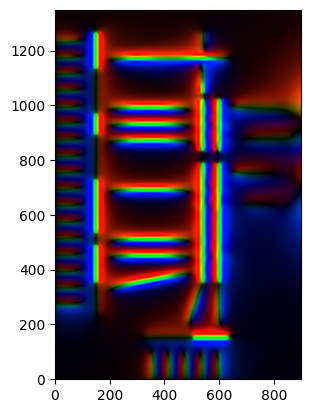

In [85]:
mostrar(Vbbs)

In [ ]:
bbs.setGrade(ate=(60, 90), h=1.5, passo=1/15)
print(f"Grade de {bbs.grade.size//3} elementos e forma{bbs.grade.shape}")
print(f"Ela se extende de {bbs.grade[0,0,0]} a {bbs.grade[-1,-1,-1]}.")

Grade de 1215000 elementos e forma(900, 1350, 1, 3)
Ela se extende de [0.  0.  1.5] a [59.933334 89.933334  1.5     ].


In [ ]:
Ebbs = bbs.CampoEletrico()

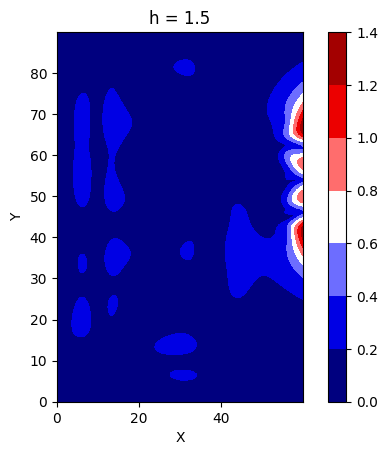

In [ ]:
contorno(norma0(Ebbs), bbs.grade)

# Outros Testes

Tensão máxima: 20.766794
9.999947916666667 % dos pontos estão acima de 6.372181415557861,
e 1 % está acima de 15.025268545150771.

O maior valor calculado foi de 20.766794204711914, no índice 
(392, 1869)
Este valor é 7.380573749542236 vezes superior à media, de 2.8137099742889404.


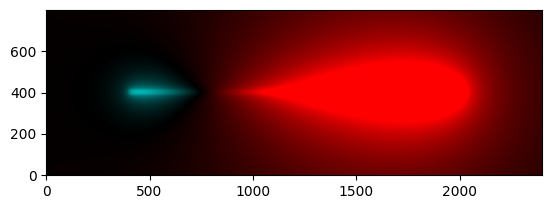

In [ ]:
desde=(0., -5.)
ate=(30., 5.)
# formagrade=(240, 80, 1)
# grade = novagrade(desde, ate, formagrade, np.float32)

segsteste = cp.array([ ((5.,0.,10.0), (25.,0.,10.0)) ],dtype=cp.float32)
qteste = cp.array([[1, 4/20]], dtype=cp.complex64)
# qteste = cp.array([[1, 0]], dtype=cp.complex64)
raiosteste = cp.array([0.1])

sus = subestacao(segs=segsteste, raios=raiosteste, Q=qteste, tipo=np.float64)
sus.setGrade(desde=desde, ate=ate, passo=1/80, h=10.0)

delVsus, Vsus = sus.Gradiente(retV=True, delta=1e-5)
print("Tensão máxima:",cp.amax(cp.absolute(Vsus)))
mostrar(Vsus)

Tensão máxima: 20.766794409744527
9.999947916666667 % dos pontos estão acima de 6.37218162363309,
e 1 % está acima de 15.025268271444073.

O maior valor calculado foi de 20.766794409744527, no índice 
(1869, 392)
Este valor é 7.38057466001629 vezes superior à media, de 2.813709686082722.


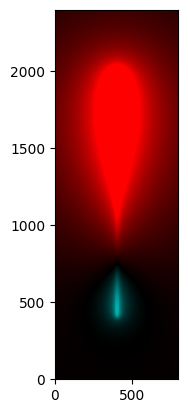

In [ ]:
segstesteT = cp.array([ ((0, 5, 10), (0, 25, 10)) ],dtype=cp.float32)

susT = subestacao(segs=segstesteT, raios=raiosteste, Q=qteste, tipo=np.float64)
susT.setGrade(desde=desde[::-1], ate=ate[::-1], passo=1/80, h=10.0)

delVsusT, VsusT = susT.Gradiente(retV=True, delta=1e-5)
print("Tensão máxima:",cp.amax(cp.absolute(VsusT)))
mostrar(VsusT)

In [ ]:
Esus = CampoEletrico(sus)
EsusT = CampoEletrico(susT)

vc é F? True
pc e vra são F? True True
sr e pc são F? True True
(1, 800, 2400, 2, 1) (3, 1, 800, 2400, 1) (2, 1)
vc é F? True
pc e vra são F? True True
sr e pc são F? True True
(1, 2400, 800, 2, 1) (3, 1, 2400, 800, 1) (2, 1)


9.999947916666667 % dos pontos estão acima de 0.019876531861044044,
e 1 % está acima de 0.020429085353271176.

O maior valor calculado foi de 0.020492774704507832, no índice 
(400, 557)
Este valor é 1.530249436107961 vezes superior à media, de 0.013391787130227076.
0.020492774704507832


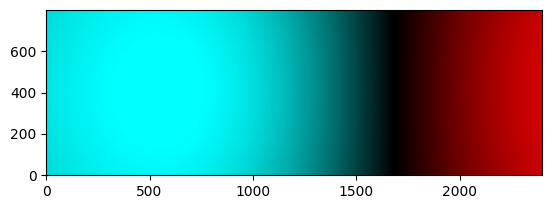

In [ ]:
# EPar
dim = 0 # x
mostrar(Esus[dim]+delVsus[dim])
print(cp.amax(cp.absolute(Esus[dim]+delVsus[dim])))

9.999947916666667 % dos pontos estão acima de 0.019876531861044044,
e 1 % está acima de 0.020429085353271176.

O maior valor calculado foi de 0.020492774704507832, no índice 
(557, 400)
Este valor é 1.5302494361079602 vezes superior à media, de 0.013391787130227083.
0.020492774704507832


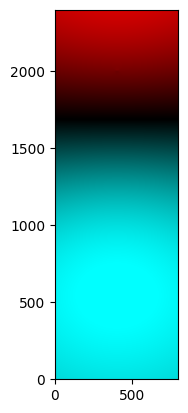

In [ ]:
# EPar
dim = 1 # y
mostrar(EsusT[dim]+delVsusT[dim])
print(cp.amax(cp.absolute(EsusT[dim]+delVsusT[dim])))

10.0 % dos pontos estão acima de 0.009234986004783308,
e 1 % está acima de 3.0424904746534693.

O maior valor calculado foi de 57.482486411024865, no índice 
(392, 1967)
Este valor é 335.8246525248736 vezes superior à media, de 0.17116815569925228.
57.482486411024865


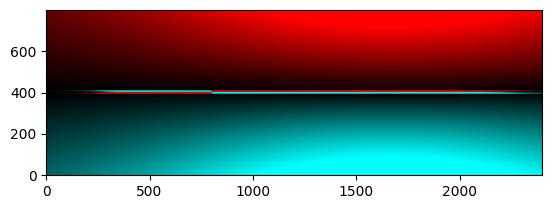

In [ ]:
# EOrt
dim = 1 # y
mostrar(Esus[dim]+delVsus[dim])
print(cp.amax(cp.absolute(Esus[dim]+delVsus[dim])))

10.0 % dos pontos estão acima de 0.009234986004783308,
e 1 % está acima de 3.0424904746534693.

O maior valor calculado foi de 57.482486411024865, no índice 
(1967, 392)
Este valor é 335.82465252487367 vezes superior à media, de 0.17116815569925226.
57.482486411024865


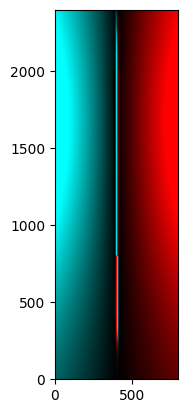

In [ ]:
# EOrt
dim = 0 # x
mostrar(EsusT[dim]+delVsusT[dim])
print(cp.amax(cp.absolute(EsusT[dim]+delVsusT[dim])))